In [1]:
%pip install keras
%pip install tensorflow
%pip install pydot
%pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


programador = "Vasco"
RSEED = 0

In [3]:
#para fazer a leitura das imagens de diferentes tamanhos
labels = ['no', 'yes']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] # RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Weight for class 0: 1.29
Weight for class 1: 0.82


C:\Users\Vasco Costa\AppData\Local\Temp\ipykernel_20752\3250579266.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


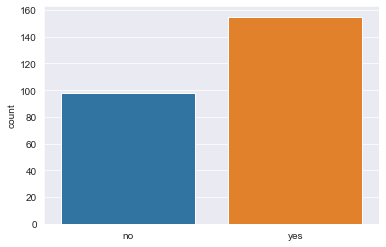

In [4]:
if programador == "Vasco_portatil":
    data = get_data("C:\\Users\\Vasco\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Vasco":
    data = get_data("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Tiago":
    data = get_data("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\dataset")

#print(data)
l = []
count_0 = 0
count_1 = 0
for i in data:
    if(i[1] == 0):
        l.append(labels[0])
        count_0 += 1
    else:
        l.append(labels[1])
        count_1 += 1
sns.set_style('darkgrid')
sns.countplot(l)

weight_for_0 = (1 / count_0)*(count_0+count_1)/2.0 
weight_for_1 = (1 / count_1)*(count_0+count_1)/2.0 

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Text(0.5, 1.0, 'yes')

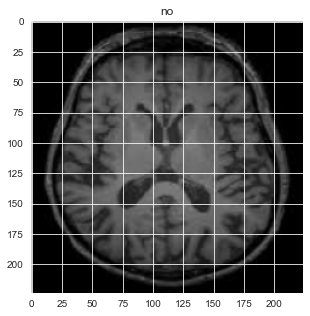

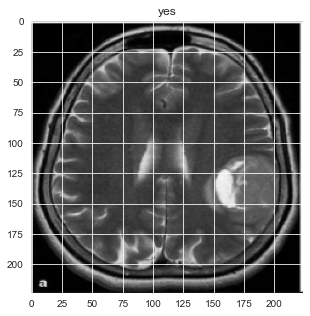

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(data[1][0])
plt.title(labels[data[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(labels[data[-1][1]])

In [6]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

x = np.array(x) / 255
#x = x[..., np.newaxis]
y = np.array(y).reshape((-1,1))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RSEED)

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

tf.keras.backend.clear_session()
input_shape = (img_size, img_size, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False
model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())
model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc', f1_m, precision_m, recall_m])

model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor=f1_m, verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="f1_m", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [early]

history = model_vgg19.fit(x_train,y_train,
        validation_data=(x_test,y_test),
        epochs=40, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weights)

Epoch 1/40
6/6 [==============================] - 17s 3s/step - loss: 0.7252 - acc: 0.5593 - f1_m: 0.4663 - precision_m: 0.5722 - recall_m: 0.5479 - val_loss: 0.7648 - val_acc: 0.5000 - val_f1_m: 0.2826 - val_precision_m: 0.6000 - val_recall_m: 0.1852
Epoch 2/40
6/6 [==============================] - 15s 3s/step - loss: 0.5273 - acc: 0.7175 - f1_m: 0.7716 - precision_m: 0.8023 - recall_m: 0.7967 - val_loss: 0.4755 - val_acc: 0.8026 - val_f1_m: 0.8168 - val_precision_m: 0.9722 - val_recall_m: 0.7057
Epoch 3/40
6/6 [==============================] - 15s 3s/step - loss: 0.4064 - acc: 0.7910 - f1_m: 0.8071 - precision_m: 0.9583 - recall_m: 0.7053 - val_loss: 0.3322 - val_acc: 0.8421 - val_f1_m: 0.8604 - val_precision_m: 0.9028 - val_recall_m: 0.8353
Epoch 4/40
6/6 [==============================] - 15s 3s/step - loss: 0.3685 - acc: 0.8362 - f1_m: 0.8811 - precision_m: 0.8397 - recall_m: 0.9310 - val_loss: 0.5924 - val_acc: 0.7500 - val_f1_m: 0.7156 - val_precision_m: 0.9697 - val_recall_m:

In [10]:
train_result = model_vgg19.evaluate(x_train,y_train)
val_result = model_vgg19.evaluate(x_test,y_test)

import pandas as pd
no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc','f1_m','precision_m','recall_m'])
no_augmented_df

3/3 [==============================] - 5s 1s/step - loss: 0.3249 - acc: 0.8553 - f1_m: 0.8820 - precision_m: 0.9236 - recall_m: 0.8459


,Train,Val
Loss,0.067914,0.324886
Acc,1.000000,0.855263
f1_m,1.000000,0.882039
precision_m,1.000000,0.923611
recall_m,1.000000,0.845900


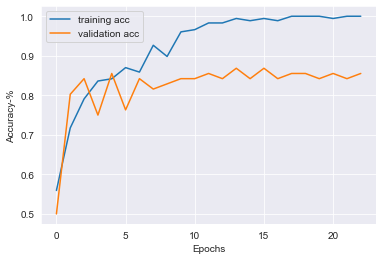

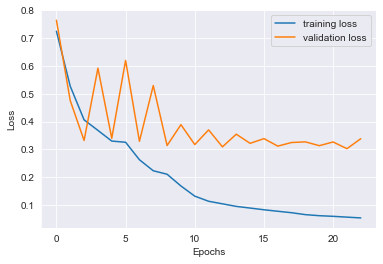

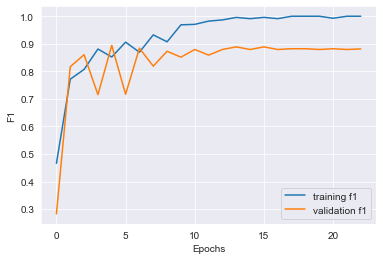

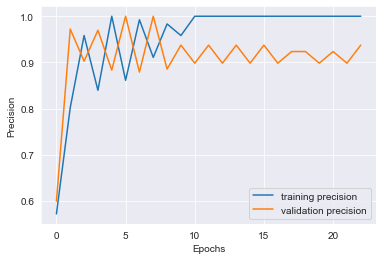

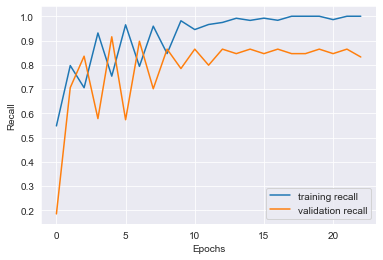

In [11]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    precision = history.history['precision_m']
    val_precision = history.history['val_precision_m']
    recall = history.history['recall_m']
    val_recall = history.history['val_recall_m']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\vgg19_f1_acc.png")
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\vgg19_f1_loss.png")
    plt.figure()

    plt.plot(epochs, f1, label='training f1')
    plt.plot(epochs, val_f1, label='validation f1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\vgg19_f1_f1.png")
    plt.figure()

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='validation precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\vgg19_f1_precision.png")
    plt.figure()

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='validation recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\vgg19_f1_recall.png")

plot_learning_curve(history)

In [12]:
ypred_val = model_vgg19.predict(x_test)
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])

print(confusion_matrix(y_test, ypred_val))
print('\n',classification_report(ypred_val,y_test))

3/3 [==============================] - 5s 1s/step
[[23  4]
 [ 7 42]]

               precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.86      0.91      0.88        46

    accuracy                           0.86        76
   macro avg       0.85      0.84      0.85        76
weighted avg       0.86      0.86      0.85        76

